In [7]:
# 사용할 패키지를 import합니다
import sys
print('python', sys.version)

import numpy as np
import pandas as pd
import matplotlib as mpl

import glob
import pickle
import matplotlib.pyplot as plt
plt.rc("font", family="Malgun Gothic") # window
plt.rc("axes", unicode_minus=False) # x,y축 (-)부호 표시

import seaborn as sns
from scipy.stats import hypergeom

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


python 3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]


In [8]:
def get_weighted_fti(xgb_res):
    return xgb_res.iloc[:,2:].multiply(xgb_res['AUC'], axis=0).sum(axis=0)

def get_fti_emp_pval(can_code):
    fti_back_dist=[]
    for file_name in glob.glob("../n_stage_pred_BRCA_0804toPC/mid_result/xgb_result/{}_ran*.pickle".format(can_code)):
        with open(file_name, 'rb') as f:
            ran_fti= pickle.load(f)
        
        ran_fti=get_weighted_fti(ran_fti)
        fti_back_dist+=list(ran_fti)

    fti_back_dist=pd.Series(fti_back_dist).sort_values(ascending=False)

    with open("../n_stage_pred_BRCA_0804toPC/mid_result/xgb_result/{}_ori0.pickle".format(can_code), 'rb') as f:
        ori_fti= pickle.load(f)

    FS_df=get_weighted_fti(ori_fti).sort_values(ascending=False).to_frame()
    FS_df.columns=['FS']
    FS_df['epval']=FS_df['FS'].map(lambda x: np.sum(fti_back_dist>=x))/len(fti_back_dist)
    ori_fti.index = ['M{}'.format(ii+1) for ii in ori_fti.index]
    
    return fti_back_dist, FS_df , ori_fti   


In [9]:
can_code='BRCA'
fti_back_dist, FS_df, ori_fti=get_fti_emp_pval(can_code)
with open("../n_stage_pred_BRCA_0804toPC/main_result/sig_res/{}.pickle".format(can_code), 'wb') as f:
    pickle.dump(FS_df, f)

# Table S1

In [10]:
FS_df.head(10)

,FS,epval
ZNF676,0.123038,0.000000
FAM163B,0.093631,0.000000
LDOC1,0.087836,0.000000
FAM78B,0.087489,0.000000
IRF1,0.086791,0.000000
SLFNL1,0.080898,0.000012
CHRNA5,0.079513,0.000012
STK40,0.077641,0.000012
MISP,0.067333,0.000023
SPPL2C,0.063177,0.000035


In [163]:
FS_df2=FS_df.T.copy()
FS_df2.insert(0,'AUC',['-','-'])
con_df=pd.concat([FS_df2, ori_fti], axis=0, join='inner')
con_df.head()
con_df.to_csv("D:/jmjung/n_stage_pred_BRCA/main_result/table_s1.csv")

,AUC,ZNF676,FAM163B,LDOC1,FAM78B,IRF1,SLFNL1,CHRNA5,STK40,MISP,...,CCDC88A,EBF1,NXF2B,MCM3AP,ANKRD12,EEF1AKMT4,FAM160B1,GSC2,NKG7,TMEM265
FS,-,0.123038,0.093631,0.087836,0.087489,0.086791,0.080898,0.079513,0.077641,0.067333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
epval,-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000012,0.000012,0.000012,0.000023,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
M1,0.626066,0.025571,0.004809,0.000000,0.003760,0.013501,0.002462,0.000000,0.000174,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M2,0.49347,0.000128,0.000000,0.000257,0.000000,0.000000,0.000344,0.000000,0.000000,0.023449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M3,0.56903,0.004829,0.001019,0.004816,0.004417,0.000000,0.000000,0.000000,0.004428,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Fig 2

<Axes: ylabel='Frequency'>

<Axes: ylabel='Frequency'>

0.024195191126156004

0.013451957318838489

0.01041735500791795

Text(0.03, 0.99, '(a)')

Text(0.53, 0.99, '(b)')

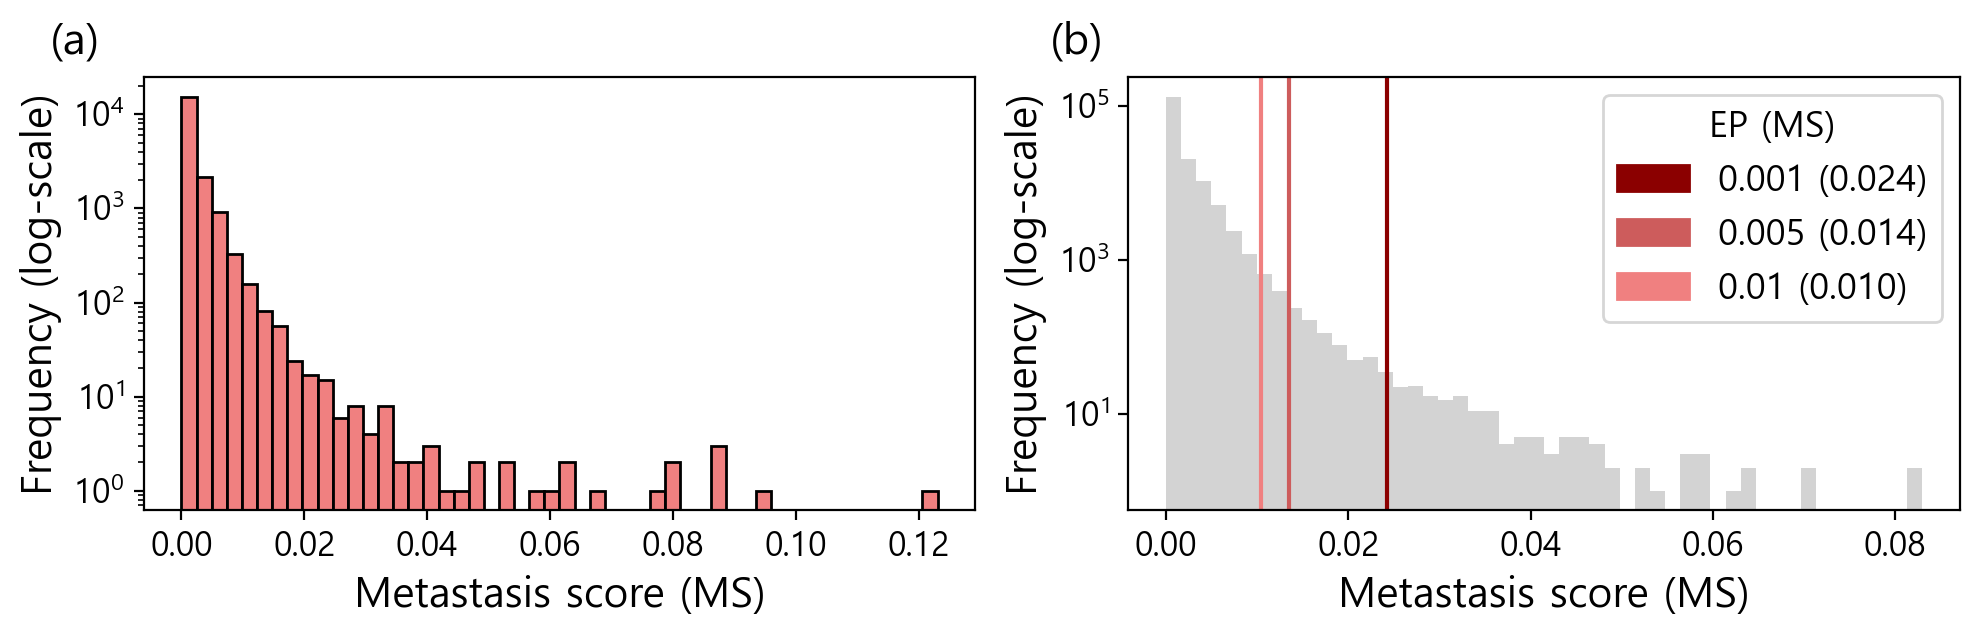

In [15]:
fig = plt.figure(figsize=(10,3), dpi=200)
ax=fig.subplots(1,2)

## fig 1a
FS_df['FS'].plot.hist(logy=True, ax=ax[0], bins=50, edgecolor='k', color='lightcoral')
_=ax[0].set_ylabel('Frequency (log-scale)', fontsize=15)
_=ax[0].set_xlabel('Metastasis score (MS)', fontsize=15)
_=ax[0].tick_params(axis='both', labelsize=12)

## fig 1b
fti_back_dist.plot.hist(logy=True, ax=ax[1], bins=50, color='lightgrey')

for th, col in zip([0.001, 0.005, 0.01], ['darkred','indianred','lightcoral']):
    sig_fti=fti_back_dist.iloc[int(len(fti_back_dist)*th)]
    sig_fti
    _=ax[1].axvline(sig_fti, label=th, color=col)
_=ax[1].set_ylabel('Frequency (log-scale)', fontsize=15)
_=ax[1].set_xlabel('Metastasis score (MS)', fontsize=15)
_=ax[1].tick_params(axis='both', labelsize=12)

# legend
col_dic = {'0.001 (0.024)':'darkred', '0.005 (0.014)':'indianred', '0.01 (0.010)':'lightcoral'}         
labels = list(col_dic.keys())
handles = [plt.Rectangle((0,0),1,1, color=col_dic[label]) for label in labels]
_=ax[1].legend(handles, labels, title='EP (MS)', fontsize=13, title_fontsize=13)
    
##
fig.text(0.03,0.99,'(a)', fontsize=16)
fig.text(0.53,0.99,'(b)', fontsize=16)

fig.tight_layout()